# Intro to Spike Sorting using SpikeInterface Demo - Hussaini Lab
<div style="text-align: right"> <font color='black'>- by Dilip Rajeswari</font>  </div>

For this demo session, we'll walk through the basics of using `SpikeInterface` <font color='blue'>(AP Buccino et al., 2020)</font>, a python module designed to improve the accessibility, reliability, and reproducibility of spike sorting and all its associated computations, for extracellular analysis and spike sorting comparison. 

SpikeInterface wraps 5 subpackages:

`spikeextractors` - Python-based module for extracting recorded and spike sorted extracellular data from any file format <br>
`spikesorters` - Python-wrappers to spike sorting algorithms <br>
`spiketoolkit` - Python-based tools for pre-, post-processing, validation, and curation <br>
`spikecomparison` - Python package for comparing spike sorting output <br>
`spikewidgets` - Python plots and widgets relevant to spike sorting and electrophysiology <br>


### Dataset for this demo anlaysis

For this demo analysis, we will be using a recording from hippocampus CA1 (recording from [CINPLA](https://www.mn.uio.no/ibv/english/research/sections/fyscell/cinpla/)) using two microdrives (one per hemisphere) with four tetrodes each (32 channels in total). The duration is about 10 min. The dataset can be downloaded from Zenodo - [open-ephys-dataset](https://doi.org/10.5281/zenodo.4657314).


### Overview of the Demo Notebook
In this Demo Notebook, we'll walk through the spike sorting steps and compare between two spike sorting packages:

1. Load the data (cambridge_data) using the spikeextractors package <br>
2. Load the probe information using SpikeInterface's ProbeInterface <br>
3. Preprocess the recorded signals <br>
      a. Filtering
4. Run three popular spike sorting algorithm - Kluster, MountainSort, and IronClust - with different parameters <br>
      a. Spike Detection  <br>
      b. Feature extraction <br>
      c. Clustering  
5. Postprocessing and data curating the spike sorting output <br>
      a. quality metrics (automatic) <br>
      b. consensus-based 
6. Challanges/Limitations of Spike sorting <br>

<b>Note</b>: We could additionally use manual spike sorters : [Phy](https://github.com/cortex-lab/phy)

### Spike sorting strategy

1) <b>Filtering</b>: A bandpass filter is applied (e.g. between 300 Hz and 3000 Hz) to keep the most useful part of the spectrum for spike sorting <br>
2) <b>Spike Detection</b>: Spikes are detected, usually using an amplitude threshold applied to the filtered data <br>
3) <b>Feature extraction</b>: Relevant features of the spike shapes are extracted, achieving a dimensionality reduction <br>
4) <b>Clustering</b>: The relevant features are used as input to a clustering algorithm that performs the classification of the waveforms and associate each cluster to a unit <br>


![alt text](Spike_sorting_steps.jpg)


<div style="text-align: right"> <font color='blue'>(HG Rey et al., 2015)</font>  </div>


### Importing the required libraries

Let's now import all five subpackages of `spikeinterface` module that we need for this analysis.

In [1]:
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

### Loading data recording

In [2]:
se.recording_extractor_full_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.mearecextractors.mearecextractors.MEArecRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.exdirextractors.exdirextractors.ExdirRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysNPIXRecordingExtractor,
 spikeextractors.extractors.intanrecordingextractor.intanrecordingextractor.IntanRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spyking

In [3]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysNPIXRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxwell

In [4]:
recording_folder = 'open-ephys-dataset/'
recording = se.OpenEphysRecordingExtractor(recording_folder)

Loading Open-Ephys: reading settings...
Decoding data from  binary  format
Reading oebin file


A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `OpenEphysRecording` is designed specifically for open-ephys datasets.

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [5]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Sampling frequency: 30000
Number of channels: 32


The `get_traces()` function returns a NxT numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

Here, the data (recording) is recorded for a total of 10 minutes at 30000 Hz. We sample data from 2s to 4s. Therefore, N is 32 and T is (4-2)*30000=60000

In [6]:
trace_snippet = recording.get_traces(start_frame=int(fs*2), end_frame=int(fs*4))

In [7]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (32, 60000)


The `spikewidgets` module includes several convenient plotting functions that can be used to explore the data:

<IPython.core.display.Javascript object>


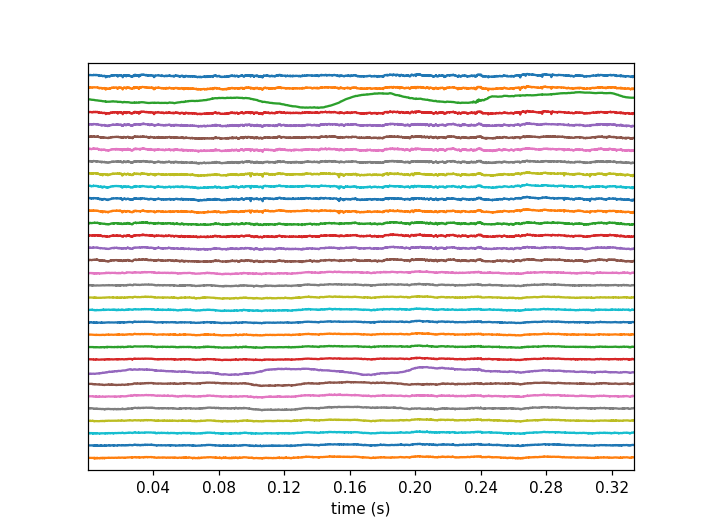

In [8]:
w_ts = sw.plot_timeseries(recording)

### Load Probe Information

We can see that the spikes mainly appear separately on different tetrodes. Each tetrode belongs to a different `group`. We can load the `group` information in two ways:

- Using the `set_channel_groups` in your RecordingExtractor (manually loading group information)
- Loading a probe file using the `load_probe_file` from RecordingExtractor (automatically loading group information)

Let's use the second option. Probe files (`.prb`) also enable users to change the channel map (reorder the channels) and add channel grouping properties and locations. In this case, our probe file will order the channels in reverse and split them in 4 groups, representing the 4 tetrodes. We'll also add locations to separate the different tetrodes.

In [9]:
# only works on linux and mac. For windows, open the file using a text editor
!cat tetrode_32.prb

channel_groups = {
    # Tetrode index
    0:
        {
        'channels': [0, 1, 2, 3],
	'geometry': [[0,0], [1,0], [2,0], [3,0]],
        },
    1:
      	{
      	'channels': [4, 5, 6, 7],
	'geometry': [[6,0], [7,0], [8,0], [9,0]],
      	},
    2:
      	{
      	'channels': [8, 9, 10, 11],
	'geometry': [[12,0], [13,0], [14,0], [15,0]],
      	},
    3:
      	{
     	 'channels': [12, 13, 14, 15],
	 'geometry': [[18,0], [19,0], [20,0], [21,0]],
     	 },
    4:
	{
        'channels': [16, 17, 18, 19],
	'geometry': [[30,0], [31,0], [32,0], [33,0]],
        },
    5:
      	{
      	'channels': [20, 21, 22, 23],
	'geometry': [[36,0], [37,0], [38,0], [39,0]],
      	},
    6:
      	{
      	'channels': [24, 25, 26, 27],
	'geometry': [[42,0], [43,0], [44,0], [45,0]],
      	},
    7:
      	{
      	'channels': [28, 29, 30, 31],
	'geometry': [[48,0], [49,0], [50,0], [51,0]],
      	}
    }


In [10]:
recording_prb = recording.load_probe_file('tetrode_32.prb')

In [11]:
print(f'Original channels: {recording.get_channel_ids()}')
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Original channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Channels after loading the probe file: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Channel groups after loading the probe file: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7]


<IPython.core.display.Javascript object>


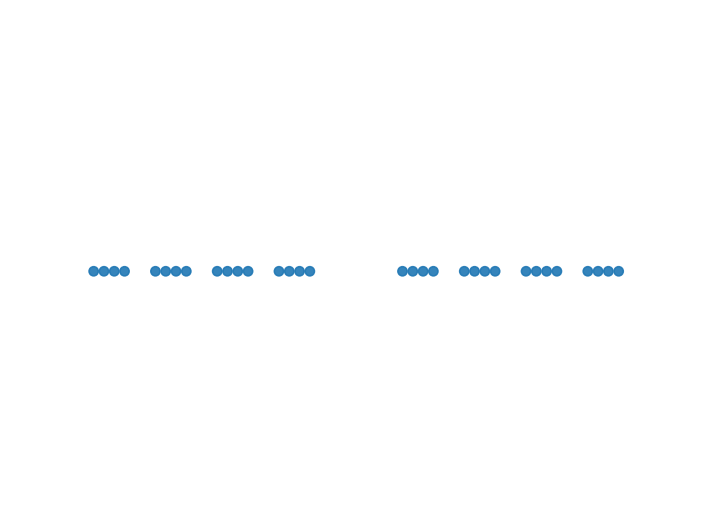

In [12]:
w_elec = sw.plot_electrode_geometry(recording_prb)

### Properties (and features)

For now we have seen that the `RecordingEctractor` can have `group` and `location` *properies*. These are very special properties that can be very important for spike sorting. Anything related to a channel can be saved as a property.

We can check which properties are in the estractor as follows:

In [13]:
print(recording.get_shared_channel_property_names())
print(recording_prb.get_shared_channel_property_names())

['gain', 'group', 'offset']
['gain', 'group', 'location', 'offset']


Let's add a new property. The first 16 channels are in the left hemisphere, the second 16 are in the right one:

In [14]:
for ch in recording_prb.get_channel_ids():
    if ch < 16:
        recording_prb.set_channel_property(ch, property_name='hemisphere', value='left')
    else:
        recording_prb.set_channel_property(ch, property_name='hemisphere', value='right')

In [15]:
print(recording_prb.get_shared_channel_property_names())

['gain', 'group', 'hemisphere', 'location', 'offset']


## Preprocessing recordings


Now that the probe information is loaded we can do some preprocessing using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc.

For this notebook, let's filter the recordings, remove a noisy channel, and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording, remove channel 2, and apply common median reference to the original recording.

<IPython.core.display.Javascript object>


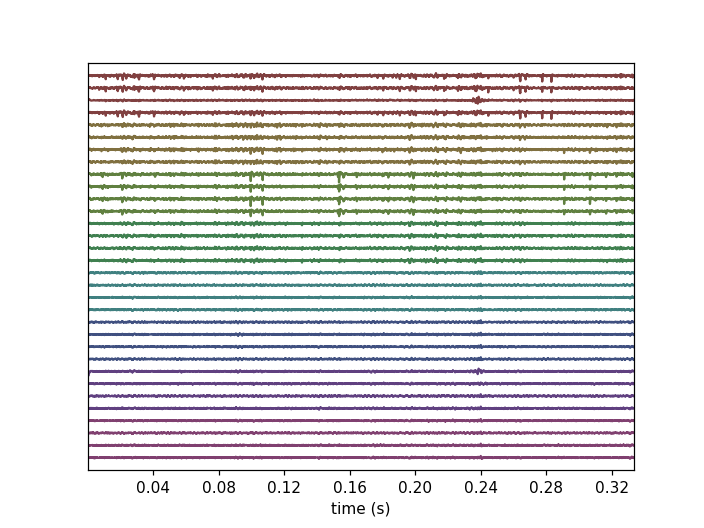

In [16]:
recording_f = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f, color_groups=True)

We can see that the first drive is quite active, while the second one is not. For sake of time, we can just focus on the first drive (channels 0-15). We can easily select these channels and get a new extractor using the `SubRecordingExtractor`:

In [17]:
recording_1 = se.SubRecordingExtractor(recording_f, channel_ids=range(16))

Sub channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after SubRecordingExtractor: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


<IPython.core.display.Javascript object>


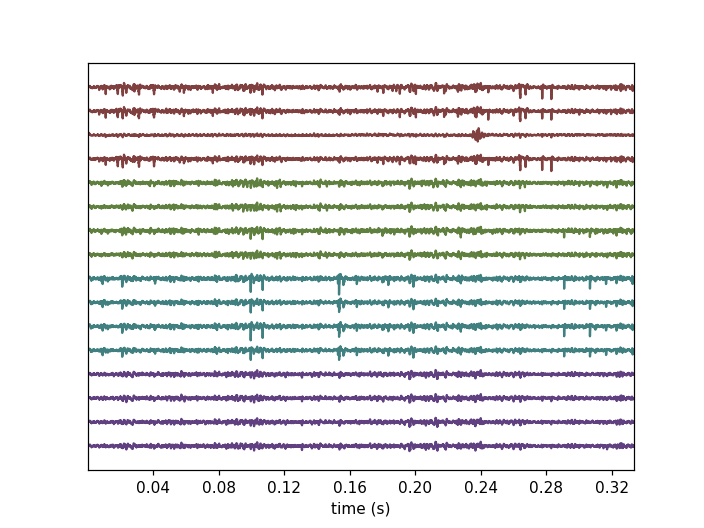

In [18]:
print(f'Sub channels: {recording_1.get_channel_ids()}')
print(f'Channel groups after SubRecordingExtractor: {recording_1.get_channel_groups()}')
w = sw.plot_timeseries(recording_1, color_groups=True)

As we can notice from the first and second plot, channel 2 seems to be a bit noisy. We can remove it using the `remove_bad_channels` function:

In [19]:
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_1, bad_channel_ids=[2])
print(f'Channel ids after removing bad channel: {recording_rm_noise.get_channel_ids()}')
print(f'Channel groups after removing bad channel: {recording_rm_noise.get_channel_groups()}')

Channel ids after removing bad channel: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after removing bad channel: [0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


In [20]:
recording_cmr = st.preprocessing.common_reference(recording_rm_noise, reference='median')

We can plot the traces after removing the bad channel and applying CMR:

<IPython.core.display.Javascript object>


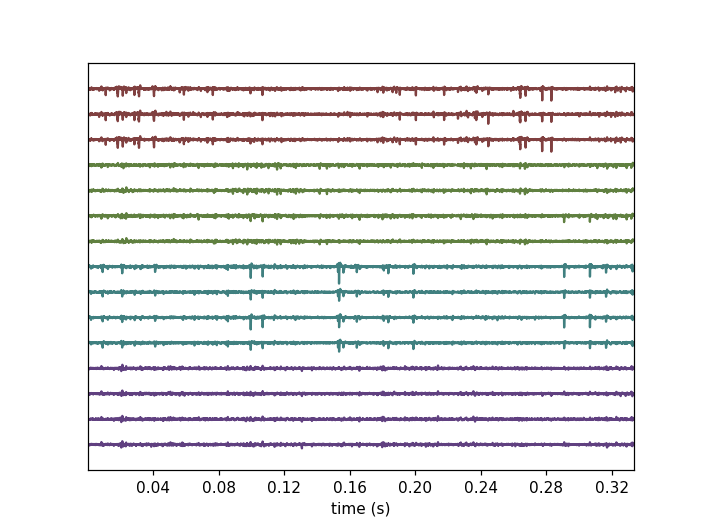

In [21]:
w = sw.plot_timeseries(recording_cmr, color_groups=True)

In [22]:
print(f'Channel ids for CMR recordings: {recording_cmr.get_channel_ids()}')
print(f'Channel groups for CMR recordings: {recording_cmr.get_channel_groups()}')

Channel ids for CMR recordings: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups for CMR recordings: [0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Since we are going to spike sort the data, let's first cut out a 2-minute recording, to speed up computations.

In [23]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = se.SubRecordingExtractor(recording_cmr, start_frame=200*fs, end_frame=320*fs)

## Caching 

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **cache** it to a file and perform those operations (eg. filters, CMR, etc.) at once. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general *post-process* the results.

In [24]:
recording_cache = se.CacheRecordingExtractor(recording_sub) 

The cached recording has all the previously loaded information:

In [25]:
print(f'Cached channels: {recording_cache.get_channel_ids()}')
print(f'Cached channels ids: {recording_cache.get_channel_ids()}')
print(f'Channel groups after caching: {recording_cache.get_channel_groups()}')

Cached channels: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cached channels ids: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after caching: [0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Under the hood, this convenient function is retrieving all the traces (in chunks, to save up some memory), applying the preprocessing steps, and dumping them to a binary temporary file:

In [26]:
recording_cache.filename

'/tmp/tmps88ywdo3/tmpghmbig4k.dat'

Note that all extractors (including sorting extractors), have a temporary folder associated with it, that enables SpikeInterface to cache several data (including waveforms) and be gentle on RAM usage:

In [27]:
recording_cache.get_tmp_folder()

PosixPath('/tmp/tmps88ywdo3')

The temporary files in the tmp folder, are *temporary*, and they will be deleted when the Python session is closed (or the object destroyed). To prevent this, we can simply move the binary file to a custom location:

In [28]:
recording_cache.move_to('filtered_data.dat') 
print(recording_cache.filename)

filtered_data.dat


Alternatively, we could have passed the `save_path` argument to the `se.CacheRecordingExtractor` directly.

## Dumping

If we now closed the Python session, we would have a nice `.dat` file, but no information on how to open it! 
In order to save the state of an extractor, we can use the **dumping** mechanism.
Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:

In [29]:
recording_cache.dump_to_dict()

{'class': 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'file_path': '/mnt/Red_2/Spike_Sorting/spiketutorials/filtered_data.dat',
  'sampling_frequency': 30000,
  'numchan': 15,
  'dtype': 'float32',
  'recording_channels': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'time_axis': 0,
  'geom': None,
  'file_offset': 0,
  'gain': None,
  'is_filtered': True},
 'key_properties': {'group': array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
  'location': array([[ 0.,  0., nan],
         [ 1.,  0., nan],
         [ 3.,  0., nan],
         [ 6.,  0., nan],
         [ 7.,  0., nan],
         [ 8.,  0., nan],
         [ 9.,  0., nan],
         [12.,  0., nan],
         [13.,  0., nan],
         [14.,  0., nan],
         [15.,  0., nan],
         [18.,  0., nan],
         [19.,  0., nan],
         [20.,  0., nan],
         [21.,  0., nan]]),
  'gain': array([1., 1., 1., 1., 1., 1., 

We can now dump our extractor object, so it can be loaded in a future session. We can dump either to `.json` or to `.pkl`. Dumping to pickle also allow us to store properties (other than group and locations) and features (for `SortingExtractor` objects).

In [30]:
recording_cache.dump_to_pickle('recording.pkl')

In another session, we can pick up from where we left by loading the extractor from the pickle file:

In [31]:
recording_loaded = se.load_extractor_from_pickle('recording.pkl')

<IPython.core.display.Javascript object>


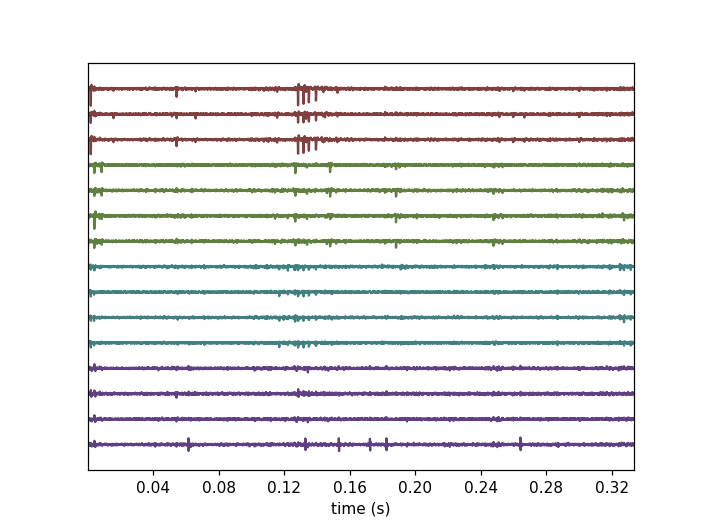

In [32]:
w = sw.plot_timeseries(recording_loaded, color_groups=True)

We can double check that the traces are exactly the same as the `recording_sub` that we dumped:

<IPython.core.display.Javascript object>


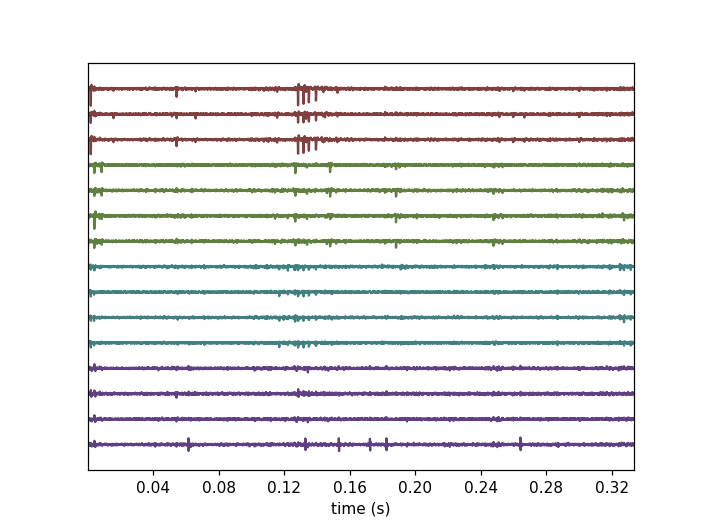

In [33]:
w = sw.plot_timeseries(recording_sub, color_groups=True)

# Spike sorting
 
We'll now run spike sorting on the above filtered recording. We will use `klusta` <font color='blue'>(C Rossant et al., 2016)</font>, `mountainsort4`  <font color='blue'>(JE Chung et al., 2017)</font> and `IronClust` for this demonstration.

We'll first check all the installed sorters in spiketoolkit to see if the required spike sorters are available. Then we can check the default parameters of the sorters.

In [34]:
# print out all the spike sorters supported by SpikeInterface
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'spykingcircus',
 'tridesclous',
 'waveclus',
 'yass']

In [35]:
# print out all the current installed spike sorters
ss.installed_sorters()

['klusta', 'mountainsort4']

### Spike sorting by group

Since we have 4 tetrodes and we know that they are physically apart, we would like to sort them separately.

Here is how it's done in SpikeInterface:

![](sort_by_group.png)


### Spike Sorting using Kluster
We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `spikesorters` module:

We will sort the bandpass cached filtered recording the `recording_cache` object.

In [36]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [37]:
ss.get_params_description('klusta')

{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'num_starting_clusters': 'Number of initial clusters',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

We will set the `adjacency_radius` to 50 microns as electrodes belonging to the same tetrode are within this distance.

In [38]:
# run spike sorting by group 
sorting_KL = ss.run_klusta(recording_cache, adjacency_radius=50, 
                                      output_folder='results_split_klusta', 
                                      grouping_property='group', parallel=True)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

Klusta found 52 units


In [39]:
print(type(sorting_KL))

<class 'spikeextractors.multisortingextractor.MultiSortingExtractor'>


In [40]:
sorting_KL.sortings

### Spike Sorting using MountainSort4
<b>Note</b>: MountainSort4 ran for >12 hours and still didn't converge. Takes too long. It seems that parallel processing is not being used properly here. To alleviate this issue, set parallet to False. 

Set filter to False as the data is already filtered.

In [41]:
# run spike sorting by group 
sorting_MS = ss.run_mountainsort4(recording_cache, adjacency_radius=50, filter=False, 
                                      output_folder='results_split_mountainsort_new', 
                                      grouping_property='group', parallel=False)
print(f'MountainSort4 found {len(sorting_MS.get_unit_ids())} units')

MountainSort4 found 36 units


### Spike Sorting using IronClust (requires MATLAB)

<b>Note:</b> IronClust accounts for drift correction

In [42]:
# clone ironclust in the current directory:
!git clone https://github.com/flatironinstitute/ironclust
    
# Now all we have to tell the IronClustSorter class where is the ironclust repo:
ss.IronClustSorter.set_ironclust_path('./ironclust')

# run IronClust
ss.IronClustSorter.ironclust_path

# print path
!echo $IRONCLUST_PATH

fatal: destination path 'ironclust' already exists and is not an empty directory.
Setting IRONCLUST_PATH environment variable for subprocess calls to: /mnt/Red_2/Spike_Sorting/spiketutorials/ironclust
/mnt/Red_2/Spike_Sorting/spiketutorials/ironclust


In [43]:
# print all installed sorters
ss.installed_sorters()

['ironclust', 'klusta', 'mountainsort4']

In [45]:
# run spike sorting by group using IronClust
sorting_IC = ss.run_ironclust(recording_cache, 
                              output_folder='results_split_ic', 
                              grouping_property='group', parallel=True, verbose=True)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

Writing to binary .dat file: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


ironclust run time 20.91s
IronClust found 13 units


Some of the functions of `SortingExtractor`:

In [46]:
print(f'Klusta unit ids: {sorting_KL.get_unit_ids()}')

Klusta unit ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [47]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(13)}')

Spike train of a unit: [  68068   68591   68770   87299   87488  170068  170228  200500  200641
  229122  229255  239064  267723  267884  269002  275245  275366  331226
  346271  349631  354774  363193  372845  372960  373118  516975  517137
  586777  586915  587049  656583  657897  659109  659256  662805  663068
  663321  695071  695224  755970  779542  779673  782671  782973  783259
  790201  790377  815008  840998  841113  899286  899439  899810  903752
  911456  911607  915652  926542  926648  946090  946223 1081431 1140752
 1204282 1204401 1292864 1292988 1293156 1340369 1340546 1357721 1357890
 1369557 1377022 1377345 1399543 1399699 1404434 1404562 1408956 1409080
 1409608 1421470 1427392 1427523 1427727 1427888 1431943 1432128 1432487
 1438595 1438727 1439047 1439638 1442930 1443041 1443255 1443575 1444297
 1451054 1451159 1454190 1454302 1458825 1461447 1461557 1462193 1462317
 1463332 1469187 1469288 1469586 1469819 1477245 1477351 1477627 1480745
 1480844 1481054 1481690 148

We can use `spikewidgets` functions to quickly visualize some unit features. Here, we plot the raster plots of the different sorters.

<IPython.core.display.Javascript object>


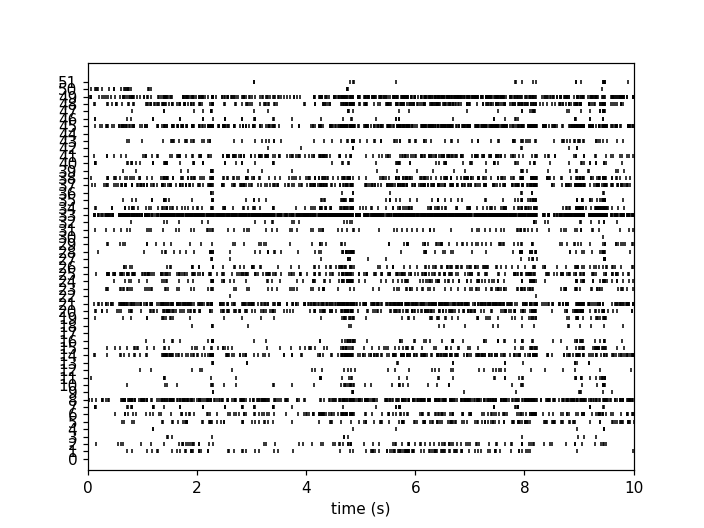

In [48]:
w_rs = sw.plot_rasters(sorting_KL, trange=[0,10])

<IPython.core.display.Javascript object>


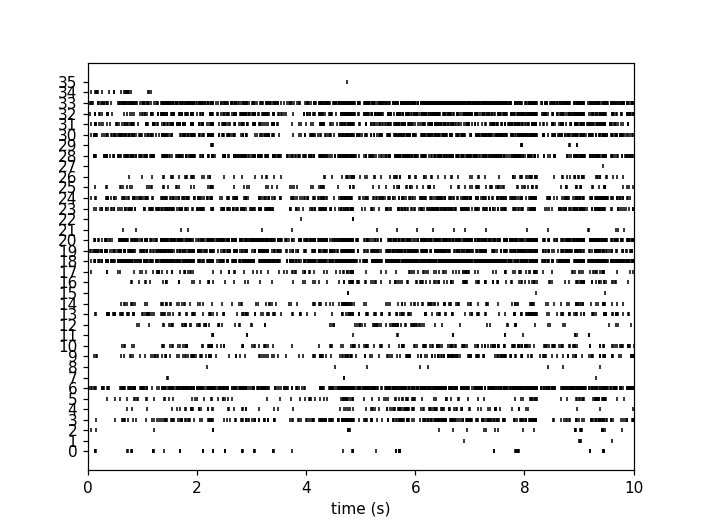

In [49]:
w_rs = sw.plot_rasters(sorting_MS, trange=[0,10])

<IPython.core.display.Javascript object>


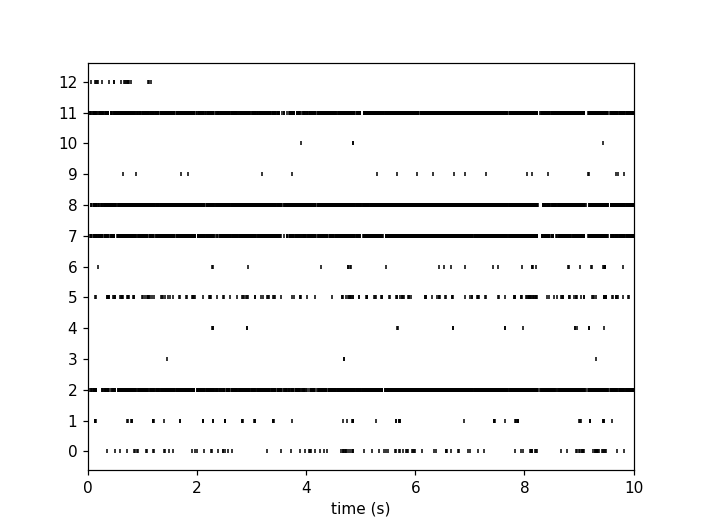

In [50]:
w_rs = sw.plot_rasters(sorting_IC, trange=[0,10])

We can now perform some automatic curation by thresholding low SNR (Signal-to-noise ratio) units on the split sorting result

### Loading a spike sorting output from a spike sorting folder

If a spike sorter has been run, you can reload the output as a `SortingExtractor` using the corresponding `spikeextractors` class. Note that if sorting by group/property, single groups must be loaded separately:

In [51]:
sorting_KL_0 = se.KlustaSortingExtractor("results_split_klusta/0")

In [52]:
print(f'Klusta unit ids group 0: {sorting_KL_0.get_unit_ids()}')

Klusta unit ids group 0: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


## Postprocessing

The `postprocessing` submodule of `spiketoolkit` allow us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

To extract the waveforms, we can run:

In [53]:
waveforms = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, verbose=True)

Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00, 17.53it/s]

Number of chunks: 1 - Number of jobs: 1


In [54]:
waveforms[0].shape

(300, 15, 180)

Similarly, we can get templates, maximum channels, and pca scores. 
Whem these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


You may have noticed that 300 waveforms were extracted from the spike train of the first unit. However, it has more spikes:

In [55]:
len(sorting_IC.get_unit_spike_train(0))

1562

It can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [56]:
sorting_IC.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

In [57]:
print(sorting_IC.get_unit_spike_features(0, 'waveforms_idxs'))

[   1    2    4    5    9   14   17   18   19   22   27   31   34   45
   52   53   54   66   80   82   85   89   96  107  108  113  122  133
  141  142  148  152  159  161  170  171  175  178  182  187  191  192
  202  204  211  219  223  227  229  233  249  253  254  259  260  268
  271  278  298  299  303  308  310  315  317  319  326  333  342  347
  353  354  360  361  364  376  379  381  393  399  402  408  412  414
  422  425  427  432  436  438  446  458  459  461  467  475  481  482
  483  489  491  494  501  506  511  512  520  529  530  538  542  558
  565  567  569  572  574  579  580  583  587  593  597  609  618  620
  621  632  638  642  644  651  654  666  667  672  682  685  686  688
  703  704  712  713  733  740  746  752  760  762  768  787  792  796
  799  801  826  831  853  874  877  878  879  883  897  898  906  916
  918  921  923  927  933  937  944  948  957  961  963  979  980  984
  986  988  989  993  997 1017 1023 1024 1026 1030 1031 1042 1059 1078
 1079 

In [58]:
waveforms_group = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, max_spikes_per_unit=None, 
                                                       grouping_property='group', recompute_info=True,
                                                       verbose=True)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:02<00:00,  2.51s/it]


In [59]:
sorting_IC.get_shared_unit_property_names()

['group', 'waveforms_channel_idxs']

In [60]:
for wf in waveforms_group:
    print(wf.shape)

(1562, 3, 180)
(767, 3, 180)
(27865, 3, 180)
(197, 3, 180)
(280, 3, 180)
(2277, 4, 180)
(1118, 4, 180)
(30520, 4, 180)
(41169, 4, 180)
(165, 4, 180)
(96, 4, 180)
(32295, 4, 180)
(153, 4, 180)


We can use `spikewidgets` to quickly inspect the spike sorting output:

In [61]:
sorting_IC.get_unit_ids()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

<IPython.core.display.Javascript object>


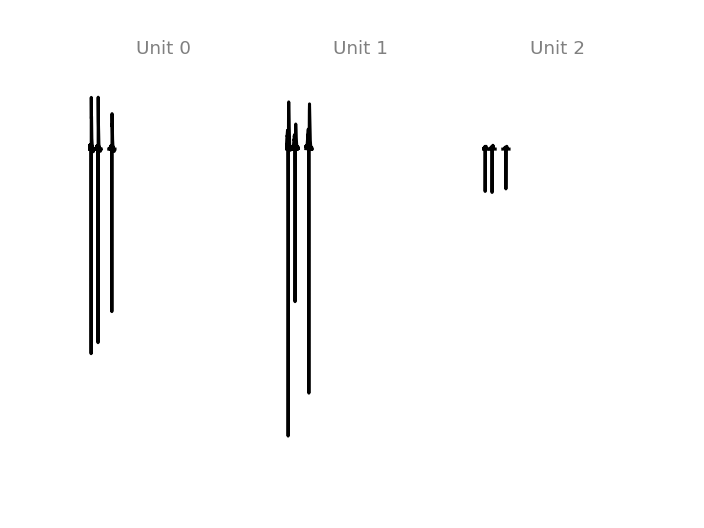

In [62]:
w_wf = sw.plot_unit_templates(sorting=sorting_IC, recording=recording_cache, unit_ids=[0,1,2])

### Compute extracellular features

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` module of `spiketoolkit` allows one to compute several of these features:

In [63]:
st.postprocessing.get_template_features_list()

['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [64]:
features = st.postprocessing.compute_unit_template_features(recording_cache, sorting_IC, as_dataframe=True, 
                                                            upsampling_factor=10)
display(features)

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.000177,0.000133,-0.258708,1.535651e+06,-44103.237726
1,0.000577,0.000163,-0.164959,1.019298e+06,-40756.580649
2,0.000783,0.000130,-0.088153,1.463908e+05,-3155.196854
3,0.000803,0.000160,-0.150921,5.323580e+05,-36700.390473
4,0.000683,0.000187,-0.217338,7.753350e+05,-60638.304101
5,0.000270,0.000170,-0.221444,6.913700e+05,-27288.399050
6,0.000843,0.000227,-0.217817,1.371738e+05,-14766.952481
7,0.001010,0.000110,-0.048124,3.032687e+05,-2007.383508
8,0.000860,0.000110,-0.053585,3.103391e+05,-1834.152044
9,0.000510,0.000117,-0.256523,9.395262e+05,-118752.175221


For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

## Validation

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:



In [65]:
st.validation.get_quality_metrics_list()

['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

We can either compute one metric at a time, or compute a subset of metrics using the `compute_quality_metrics` function:

In [66]:
duration = recording.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_IC, duration_in_frames=duration)
print('ISI violations:', isi_violations)

snrs = st.validation.compute_snrs(sorting_IC, recording_cache)
print('SNRs:', snrs)

ISI violations: [ 0.16411173  2.38220422  2.22620743  0.          0.          0.23168444
  8.64931732  2.50633094  2.26652624  0.          0.          2.34051632
 25.65724793]
SNRs: [20.808018  29.189953   4.3104944 30.753504  33.143784  14.461325
  9.493292   4.4890823  4.077184  48.354214  53.44737    3.8988655
 13.532953 ]


In [67]:
quality_metrics = st.validation.compute_quality_metrics(sorting_IC, recording_cache, 
                                                        metric_names=['firing_rate', 'isi_violation', 'snr'], 
                                                        as_dataframe=True)
display(quality_metrics)

,firing_rate,isi_violation,snr
0,13.016667,0.033157,20.808018
1,6.391667,0.481304,29.189953
2,232.208333,0.449787,4.310494
3,1.641667,0.000000,30.753504
4,2.333333,0.000000,33.143784
5,18.975000,0.046810,14.461325
6,9.316667,1.747522,9.493292
7,254.333333,0.506383,4.489082
8,343.075000,0.457933,4.077184
9,1.375000,0.000000,48.354214


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Curation

### 1) Automatic curation based on quality metrics

In [68]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [69]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)

In [70]:
len(sorting_auto.get_unit_ids())

5

In [71]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, recording_cache, snr_thresh, 'less')

In [72]:
len(sorting_auto.get_unit_ids())

5

### 2) Consensus-based curation 

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

In [73]:
mcmp = sc.compare_multiple_sorters([sorting_KL, sorting_IC, sorting_MS], ['KL', 'IC', 'MS'], spiketrain_mode='union',
                                   verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing:  KL  and  IC
  Comparing:  KL  and  MS
  Comparing:  IC  and  MS
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


<IPython.core.display.Javascript object>


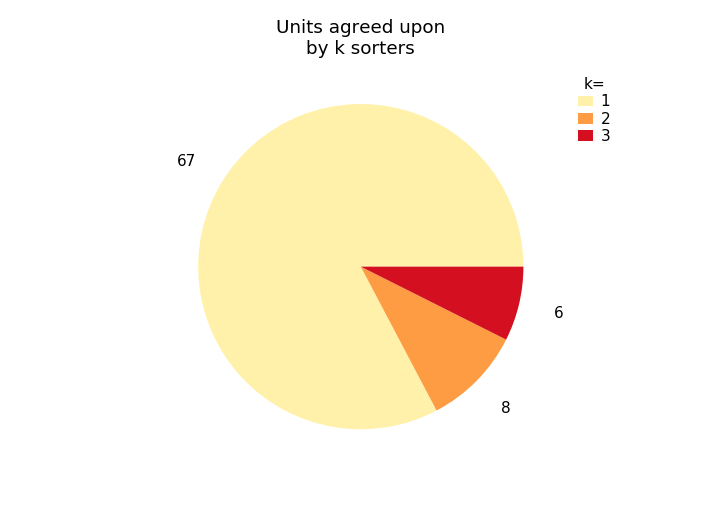

<IPython.core.display.Javascript object>


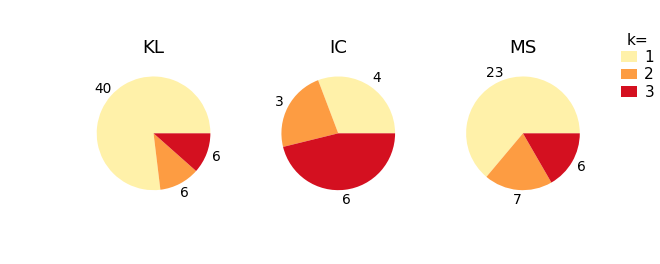

In [74]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [75]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [76]:
agreement_sorting.get_unit_ids()

[1, 5, 7, 13, 15, 18, 23, 25, 30, 39, 43, 50, 53, 56]

## Challanges/Limitations with Spike Sorting
### Variability in distinct unit detection between runs using MountainSort4

In [77]:
for i in range(5):
    sorting_MS = ss.run_mountainsort4(recording_cache, adjacency_radius=50, filter=False, 
                                          output_folder='results_split_mountainsort_new', 
                                          grouping_property='group', parallel=False)
    print(f'MountainSort4 found {len(sorting_MS.get_unit_ids())} units in run number', i+1)

MountainSort4 found 36 units in run number 1
MountainSort4 found 37 units in run number 2
MountainSort4 found 34 units in run number 3
MountainSort4 found 36 units in run number 4
MountainSort4 found 35 units in run number 5


### Other Challanges/Limitations:

- Validation of results
- Overlapping spikes
- Bursting neurons
- Electrode drifts

### Reference Articles:

    Buccino AP, Hurwitz CL, Garcia S, Magland J, Siegle JH, Hurwitz R, Hennig MH. SpikeInterface, a unified framework for spike sorting. Elife. 2020 Nov 10;9:e61834. doi: 10.7554/eLife.61834. PMID: 33170122; PMCID: PMC7704107.
    
    Chung JE, Magland JF, Barnett AH, Tolosa VM, Tooker AC, Lee KY, Shah KG, Felix SH, Frank LM, Greengard LF. A Fully Automated Approach to Spike Sorting. Neuron. 2017 Sep 13;95(6):1381-1394.e6. doi: 10.1016/j.neuron.2017.08.030. PMID: 28910621; PMCID: PMC5743236.

    Rey HG, Pedreira C, Quian Quiroga R. Past, present and future of spike sorting techniques. Brain Res Bull. 2015 Oct;119(Pt B):106-17. doi: 10.1016/j.brainresbull.2015.04.007. Epub 2015 Apr 27. PMID: 25931392; PMCID: PMC4674014.
    
    Rossant C, Kadir SN, Goodman DFM, Schulman J, Hunter MLD, Saleem AB, Grosmark A, Belluscio M, Denfield GH, Ecker AS, Tolias AS, Solomon S, Buzsaki G, Carandini M, Harris KD. Spike sorting for large, dense electrode arrays. Nat Neurosci. 2016 Apr;19(4):634-641. doi: 10.1038/nn.4268. Epub 2016 Mar 14. PMID: 26974951; PMCID: PMC4817237.
    